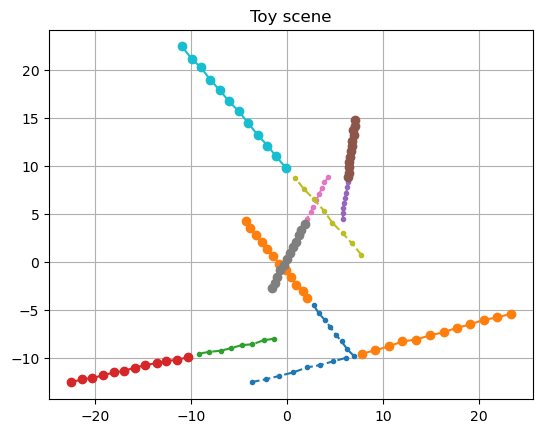

In [4]:
from utils.preprocessing import make_toy_batch
from visualize.plot import plot_scene

batch = make_toy_batch(num_scenes=1, agents_per_scene=6)
plot_scene(batch["past"][0], batch["future"][0])


In [5]:
from models.baselines import predict_cv
from evaluation.metrics import rmse, count_collisions

past, future = batch["past"][0], batch["future"][0]
pred = predict_cv(past, future.shape[1])

print("RMSE:", rmse(pred, future))
print("Collisions (pred):", count_collisions(pred))
print("Collisions (gt):", count_collisions(future))


RMSE: 0.5080116775112928
Collisions (pred): 1
Collisions (gt): 0


In [1]:
conda env export --no-builds | findstr /V "prefix:" > environment_crossplat.yml



Note: you may need to restart the kernel to use updated packages.


'conda' is not recognized as an internal or external command,
operable program or batch file.


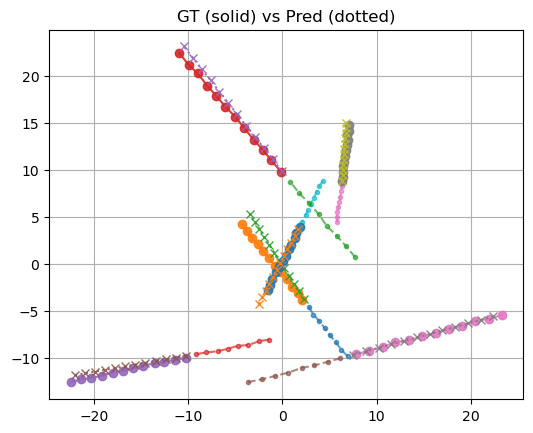

In [6]:
from visualize.plot import plot_scene
import matplotlib.pyplot as plt

def plot_pred_vs_gt(past, future, pred, title="GT (solid) vs Pred (dotted)"):
    plt.figure()
    A = past.shape[0]
    for a in range(A):
        # past
        plt.plot(past[a,:,0], past[a,:,1], "--", marker=".", alpha=0.7)
        # gt future
        plt.plot(future[a,:,0], future[a,:,1], "-", marker="o", alpha=0.9)
        # pred future
        plt.plot(pred[a,:,0],  pred[a,:,1],  ":", marker="x", alpha=0.9)
    plt.gca().set_aspect("equal"); plt.grid(True); plt.title(title)
    plt.show()

plot_pred_vs_gt(past, future, pred)


In [2]:
import fcntl
from utils.preprocessing_nuplan_single import load_nuplan_single_vehicle
from models.baselines import predict_cv
from evaluation.metrics import ade, fde, rmse

batch, agent_id = load_nuplan_single_vehicle(T_past=8, T_future=12, use_ego=True)
past   = batch["past"][0,0]    # (Tp,2)
future = batch["future"][0,0]  # (Tf,2)

pred = predict_cv(past[None, ...], future.shape[0])[0]  # (Tp,2)->(Tf,2)

print("Agent:", agent_id)
print("ADE:", ade(pred, future))
print("FDE:", fde(pred, future))
print("RMSE:", rmse(pred, future))


ModuleNotFoundError: No module named 'fcntl'